In [1]:
import os, sys

import numpy as np
import pandas as pd
import time, random, math
import copy, gc
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
import torch
from torch.optim import Adam
from torch.distributions import Categorical

In [2]:
from method_1 import SearchAvailablePosition
from method_2 import SearchAction
from method_3 import ChangeBoard

from Othello import Othello

In [3]:
from RL.train_model import get_play_data, getState
from RL.rule_agent import randomAgent, greedyAgent, RollOutAgent
from RL.optimize_model import optimize_a2cmodel as optimize_model
from RL.A2C_agent import agent as a2c_agent
from RL.DQN_agent import agent as dqn_agent
from RL.Replay_Memory import Replay_Memory
from RL.noise import AdaptiveParamNoiseSpec
from RL.utils import get_device

In [25]:
class Trainer:
    def __init__(self):
        self.win_1 = []
        self.win_2 = []
        self.agent_1 = a2c_agent(
            input_dim=3, lam=0.6, gamma=.9, lr=1e-4,
            noise=AdaptiveParamNoiseSpec(initial_stddev=0.5)
        )
        
        self.agent_2 = a2c_agent(
            input_dim=3, lam=0.6, gamma=.9, lr=1e-4,
            noise=AdaptiveParamNoiseSpec(initial_stddev=0.5)
        )
        loss = self.agent_1.init_param_optim(150)
        loss = self.agent_2.init_param_optim(150)
        
        self.memory_1 = Replay_Memory(800)
        self.memory_2 = Replay_Memory(800)
        
        self.random_agent = randomAgent()
        self.greedy_agent = greedyAgent()
        
    def make_rollout_agent(self, agent, rollout_type, rollout_num):
        if rollout_type==0:
            rollout_agent = RollOutAgent(agent, self.random_agent, rollout_num)
        if rollout_type==1:
            rollout_agent = RollOutAgent(agent, self.greedy_agent, rollout_num)
        if rollout_type==2:
            rollout_agent = RollOutAgent(self.random_agent, agent, rollout_num)
        if rollout_type==3:
            rollout_agent = RollOutAgent(self.greedy_agent, agent, rollout_num)
        return rollout_agent
    
    def make_loss_df(self):
        loss_1_df = pd.DataFrame()
        loss_1_df['loss_1'] = self.agent_1.loss_1_list
        loss_1_df['loss_2'] = self.agent_1.loss_2_list
        loss_1_df['loss_3'] = self.agent_1.loss_3_list
        loss_1_df['loss_1'] = loss_1_df['loss_1'].rolling(10,min_periods=1).mean()
        loss_1_df['loss_2'] = loss_1_df['loss_2'].rolling(10,min_periods=1).mean()
        loss_1_df['loss_3'] = loss_1_df['loss_3'].rolling(10,min_periods=1).mean()
        
        loss_2_df = pd.DataFrame()
        loss_2_df['loss_1'] = self.agent_2.loss_1_list
        loss_2_df['loss_2'] = self.agent_2.loss_2_list
        loss_2_df['loss_3'] = self.agent_2.loss_3_list
        loss_2_df['loss_1'] = loss_2_df['loss_1'].rolling(10,min_periods=1).mean()
        loss_2_df['loss_2'] = loss_2_df['loss_2'].rolling(10,min_periods=1).mean()
        loss_2_df['loss_3'] = loss_2_df['loss_3'].rolling(10,min_periods=1).mean()
        return loss_1_df, loss_2_df
    
    def train(self, iteration=2, N=100, rollout_type=None, rollout_num=16):
        for i in tqdm(range(N)):
            for _ in range(iteration):
                if rollout_type is not None:
                    tmp_agent_1 = self.make_rollout_agent(self.agent_1, rollout_type, rollout_num)
                    tmp_agent_2 = self.make_rollout_agent(self.agent_2, rollout_type, rollout_num)
                else:
                    tmp_agent_1 = np.random.choice([self.agent_1, self.greedy_agent, self.random_agent], p=[0.8,0.1,0.1])
                    tmp_agent_2 = np.random.choice([self.agent_2, self.greedy_agent, self.random_agent], p=[0.8,0.1,0.1])

                data_1, data_2 = get_play_data(tmp_agent_1 , tmp_agent_2)
                self.memory_1.push(data_1)
                self.memory_2.push(data_2)
                
            self.agent_1.optimize_model(self.memory_1)
            self.agent_2.optimize_model(self.memory_2)
        loss_1_df, loss_2_df = self.make_loss_df()
        return loss_1_df, loss_2_df
    
    def comp_agent(self, agent_1, agent_2):
        othello = Othello()
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
        while not done:
            if othello.color==1:
                setrow, setcol = agent_1.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)

            else:
                setrow, setcol = agent_2.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
            board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
            if done:
                if len(board[board==1])>len(board[board==2]):
                    result_1,result_2, draw =1,0,0
                elif len(board[board==1])<len(board[board==2]):
                    result_1,result_2, draw =0,1,0
                else:
                    result_1,result_2, draw =0,0,1
                return result_1,result_2, draw
            
    def evaluate(self, N=800):
        evaluate_df = pd.DataFrame(0, index=['agent_1', 'agent_2', 'random_agent', 'greedy_agent'], 
                                   columns=['agent_1', 'agent_2', 'random_agent', 'greedy_agent'])
        for _ in tqdm(range(800)):
            result_1,result_2, draw = self.comp_agent(self.agent_1, self.random_agent)
            evaluate_df.loc['agent_1', 'random_agent']+=result_1
            evaluate_df.loc['random_agent', 'agent_1']+=result_2
            
            result_1,result_2, draw = self.comp_agent(self.agent_1, self.greedy_agent)
            evaluate_df.loc['agent_1', 'greedy_agent']+=result_1
            evaluate_df.loc['greedy_agent', 'agent_1']+=result_2
            
            result_1,result_2, draw = self.comp_agent(self.agent_1, self.agent_2)
            evaluate_df.loc['agent_1', 'agent_2']+=result_1
            evaluate_df.loc['agent_2', 'agent_1']+=result_2
            
            result_1,result_2, draw = self.comp_agent(self.random_agent, self.agent_2)
            evaluate_df.loc['random_agent', 'agent_2']+=result_1
            evaluate_df.loc['agent_2', 'random_agent']+=result_2
            
            result_1,result_2, draw = self.comp_agent(self.greedy_agent, self.agent_2)
            evaluate_df.loc['greedy_agent', 'agent_2']+=result_1
            evaluate_df.loc['agent_2', 'greedy_agent']+=result_2
        return evaluate_df

In [27]:
trainer.agent_1, trainer.agent_2 = agent_1, agent_2

In [26]:
trainer = Trainer()

In [11]:
loss_1_df, loss_2_df = trainer.train(iteration=2, N=2000)

NameError: name 'make_loss_df' is not defined

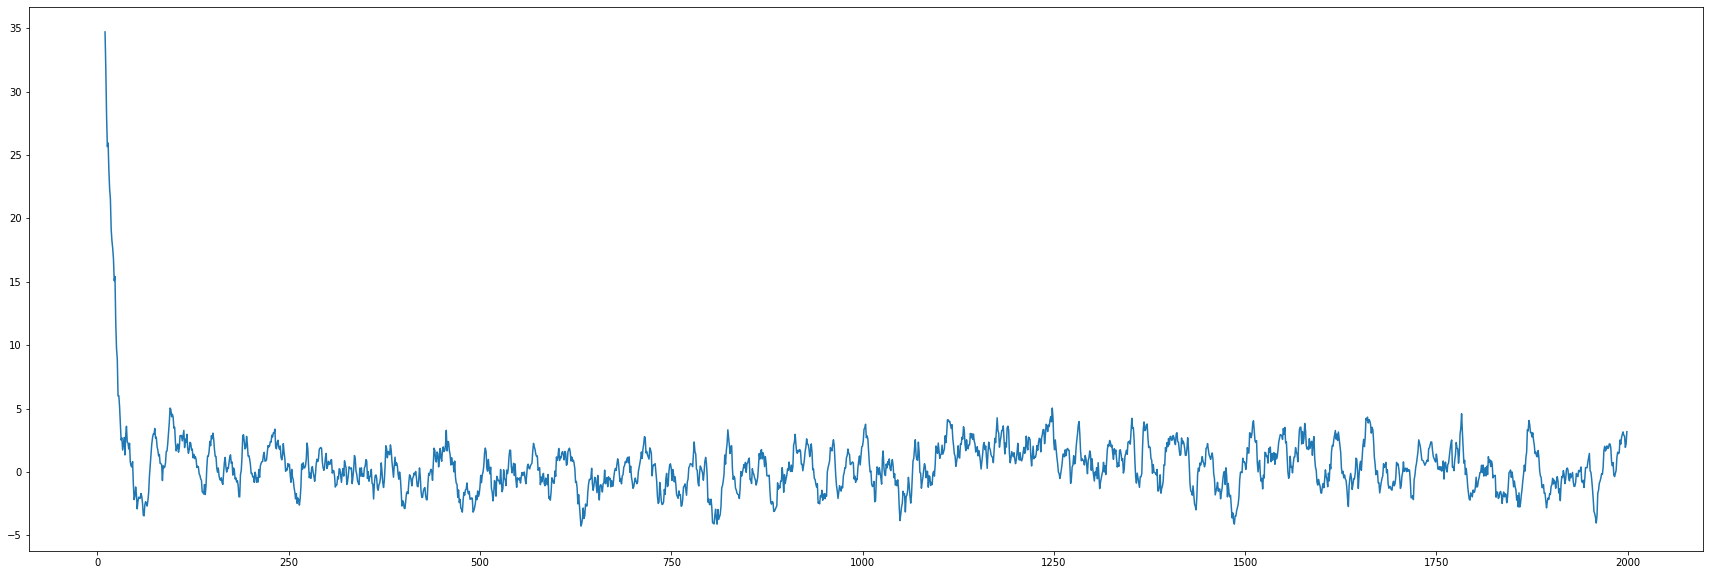

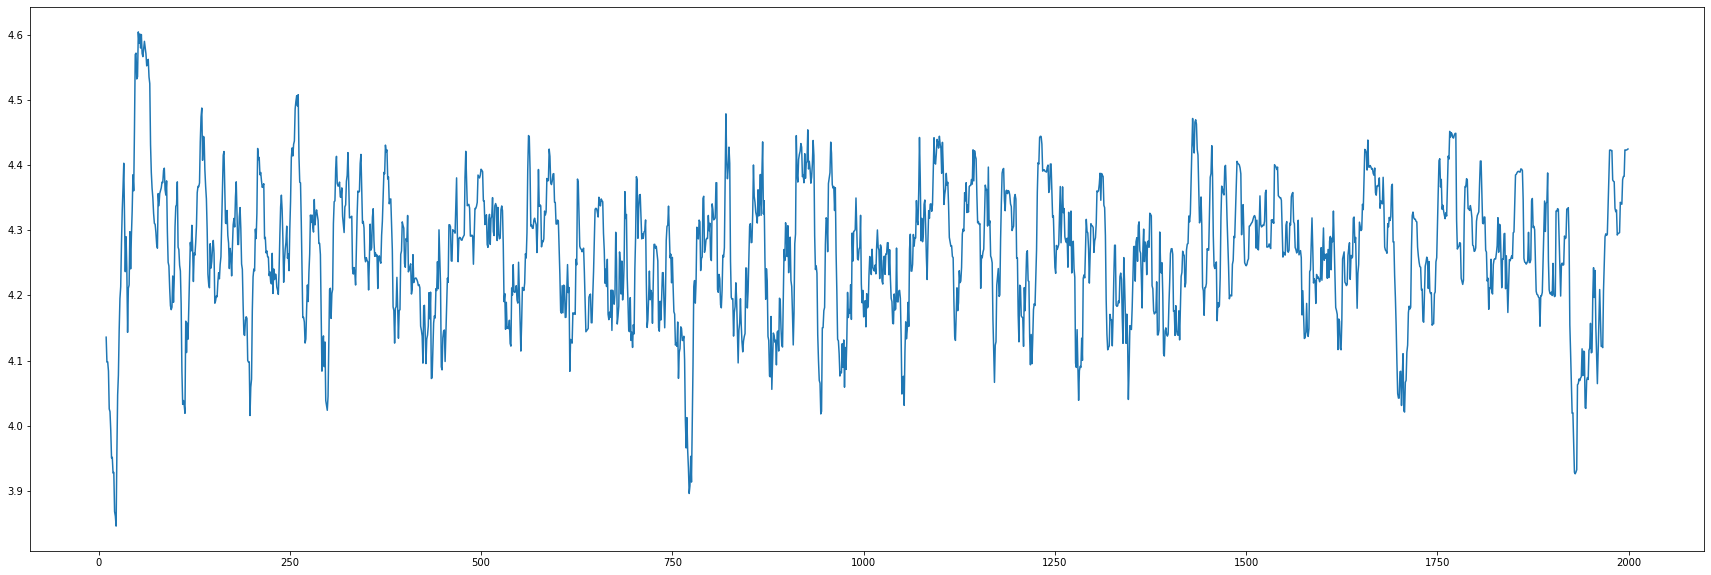

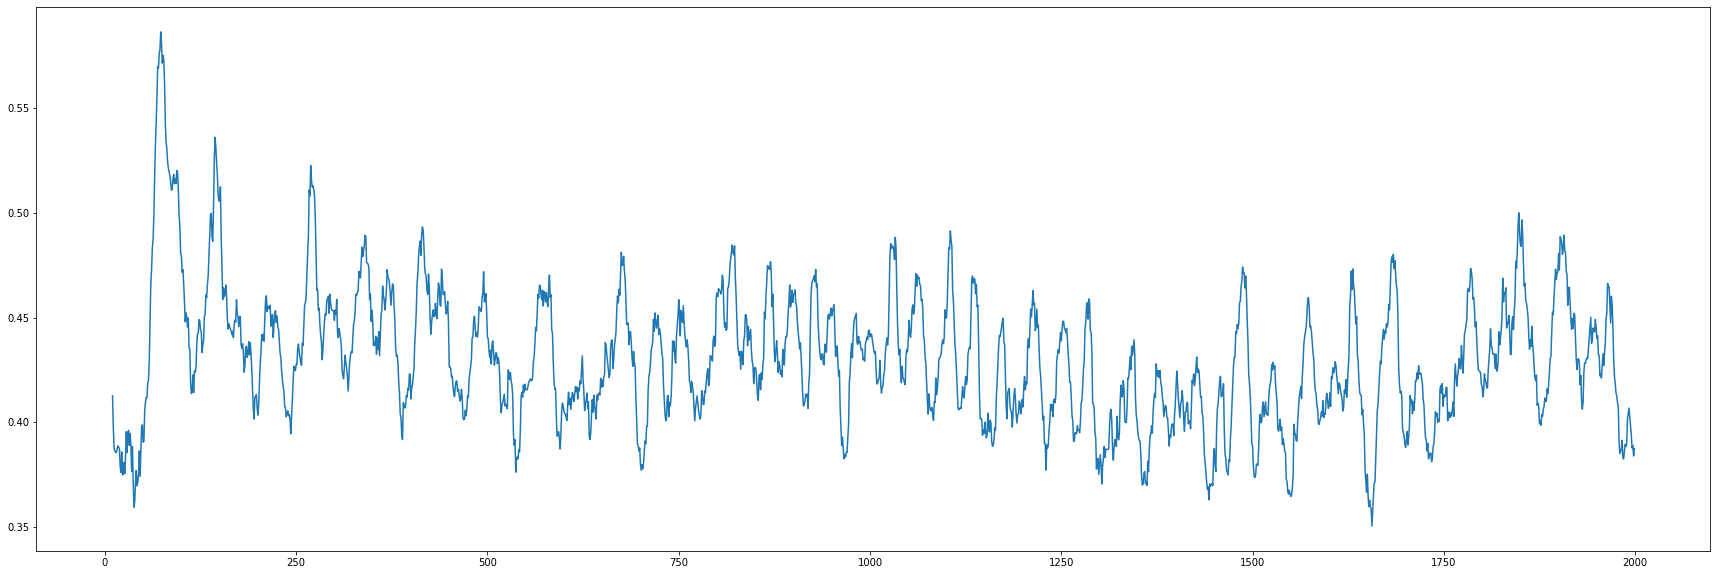

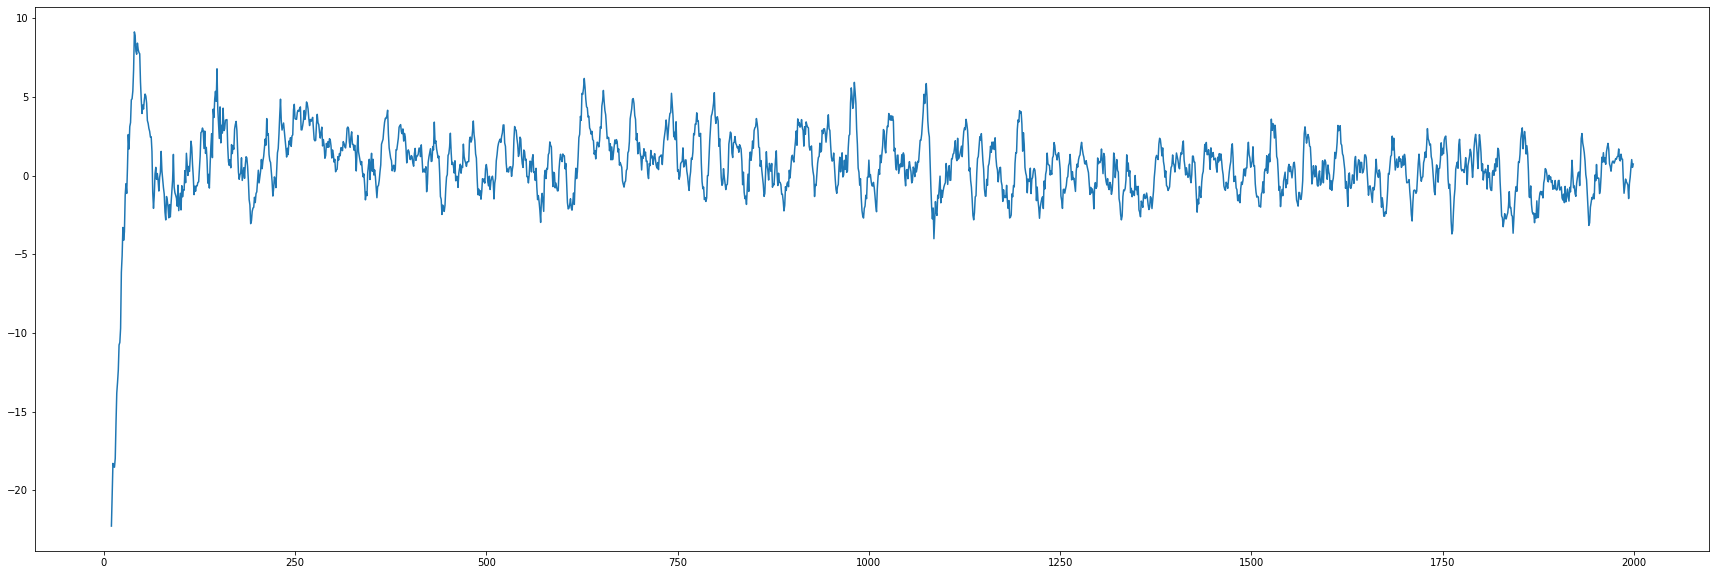

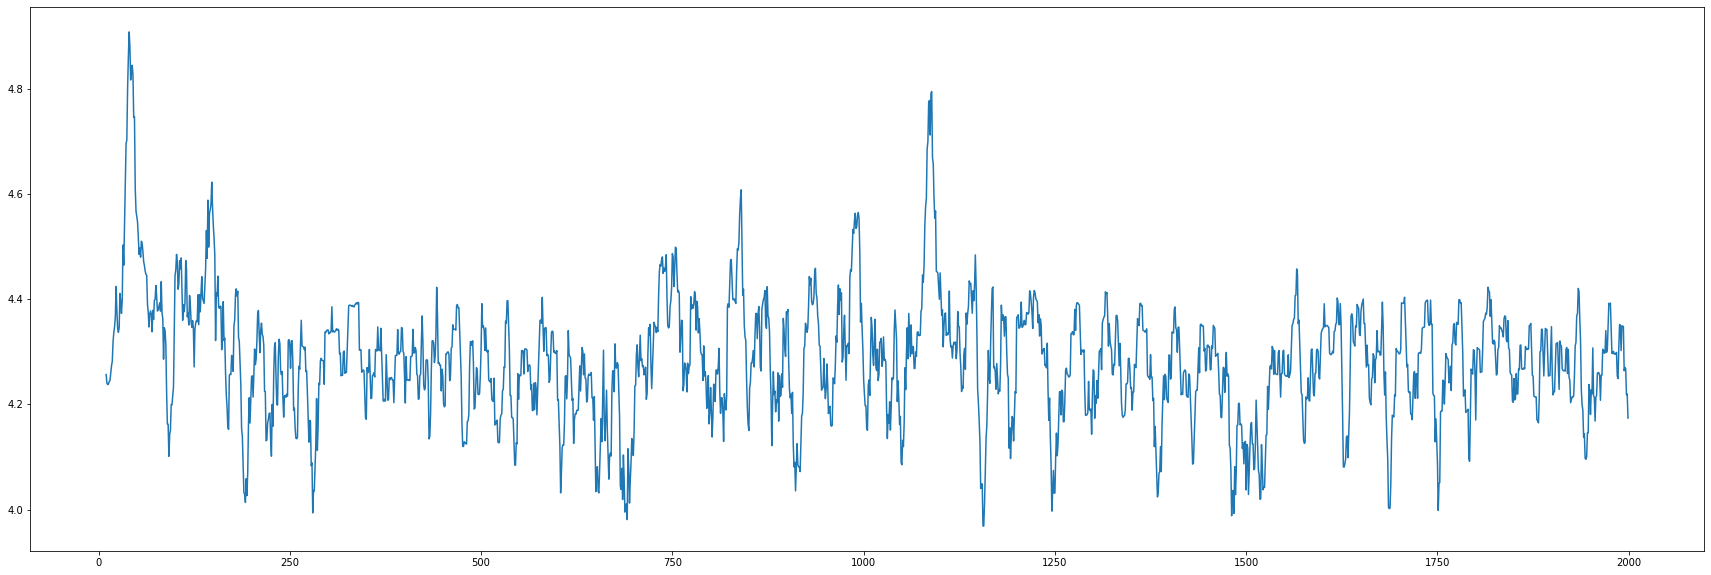

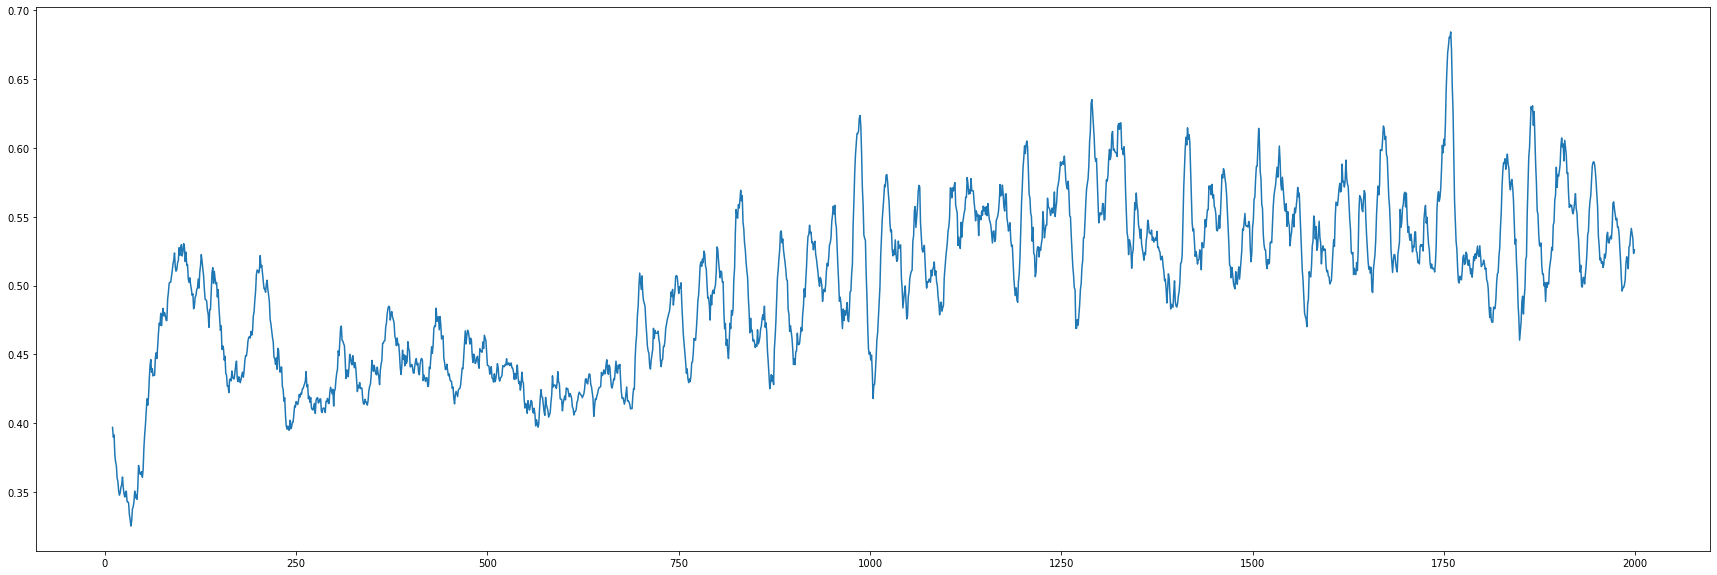

In [14]:
for i in range(3):
    plt.figure(figsize=(30,10))
    plt.plot(loss_1_df[f'loss_{i+1}'][10:])
    plt.show()
    
for i in range(3):
    plt.figure(figsize=(30,10))
    plt.plot(loss_2_df[f'loss_{i+1}'][10:])
    plt.show()

In [28]:
eval_df = trainer.evaluate()

In [29]:
eval_df

,agent_1,agent_2,random_agent,greedy_agent
agent_1,0,0,656,649
agent_2,800,0,681,635
random_agent,127,101,0,0
greedy_agent,129,147,0,0


In [30]:
loss_1_df, loss_2_df = trainer.train(iteration=2, N=500, rollout_type=0, rollout_num=16)

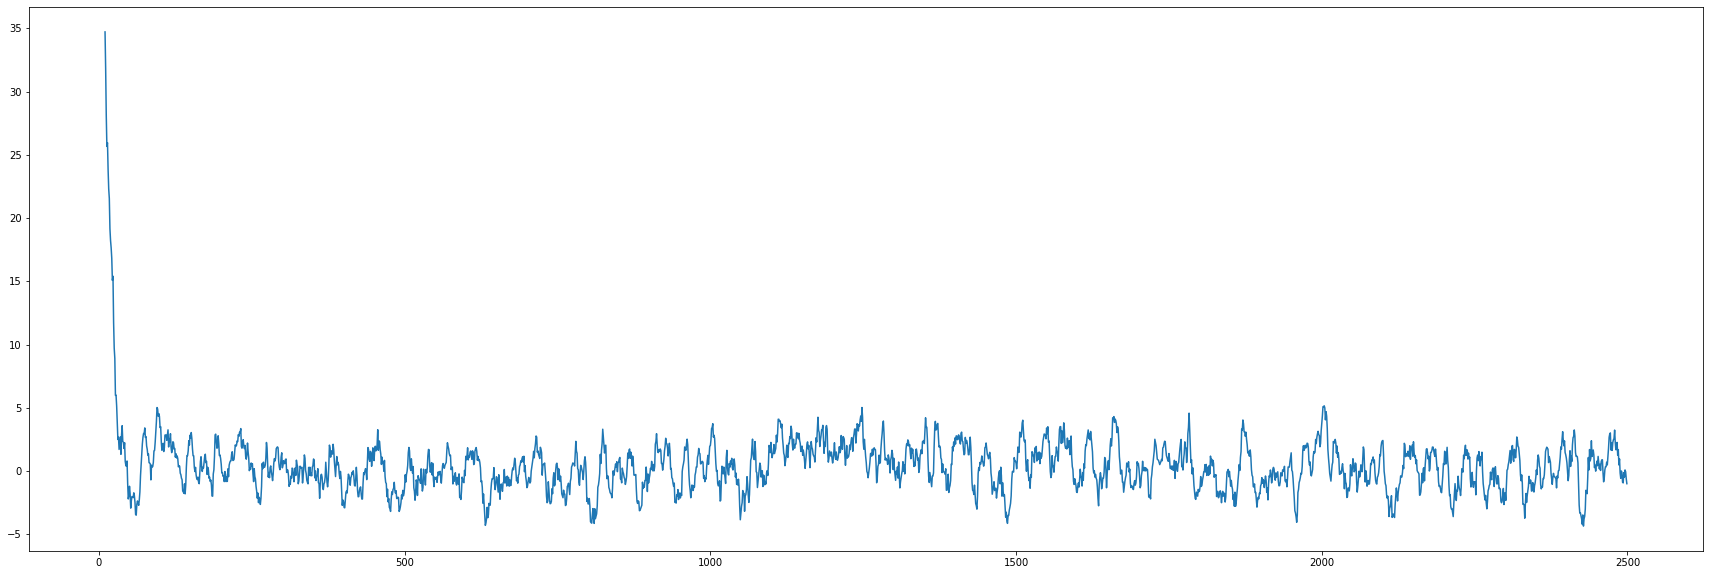

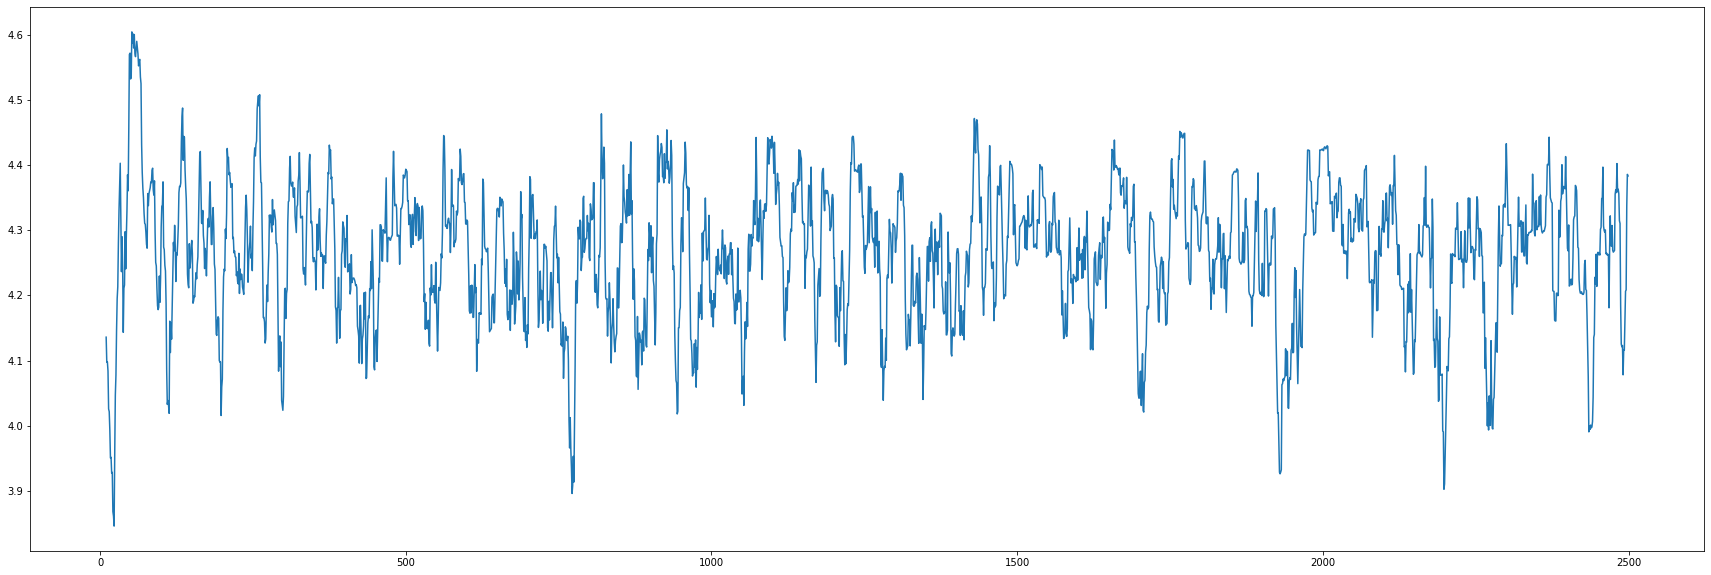

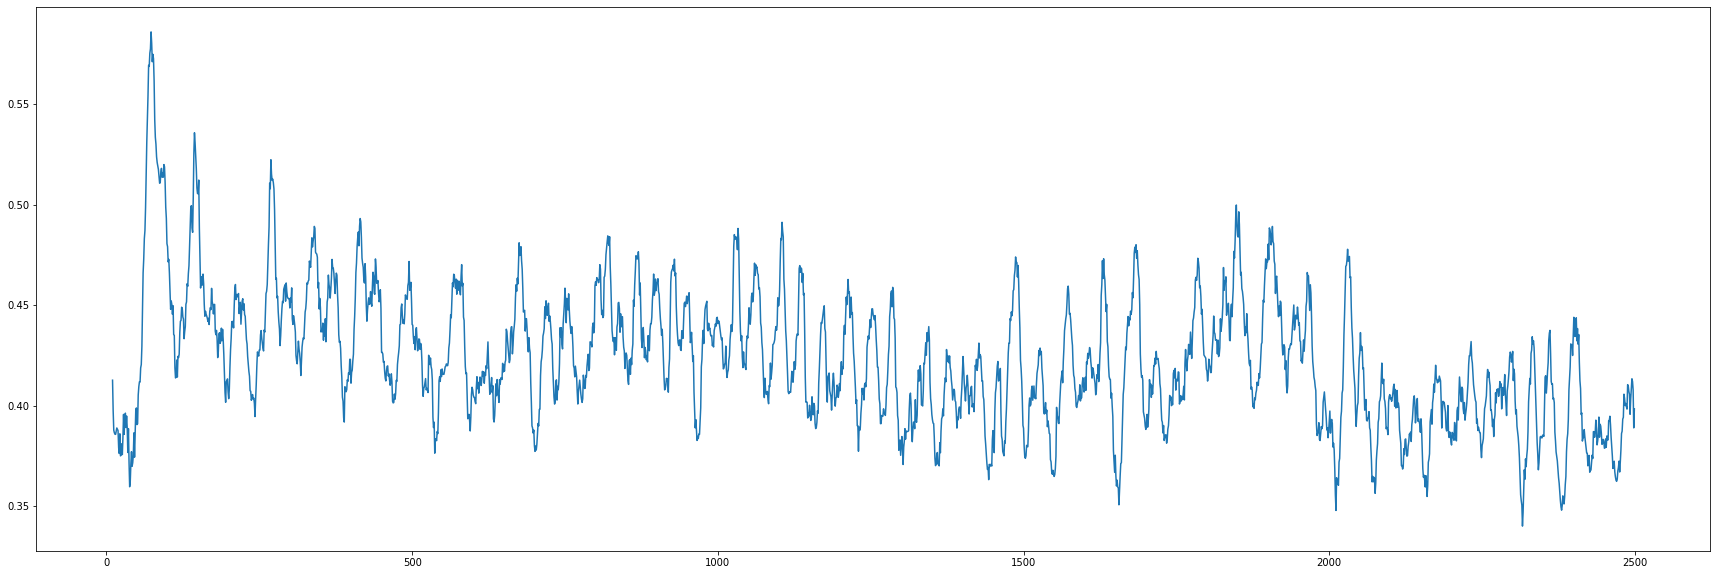

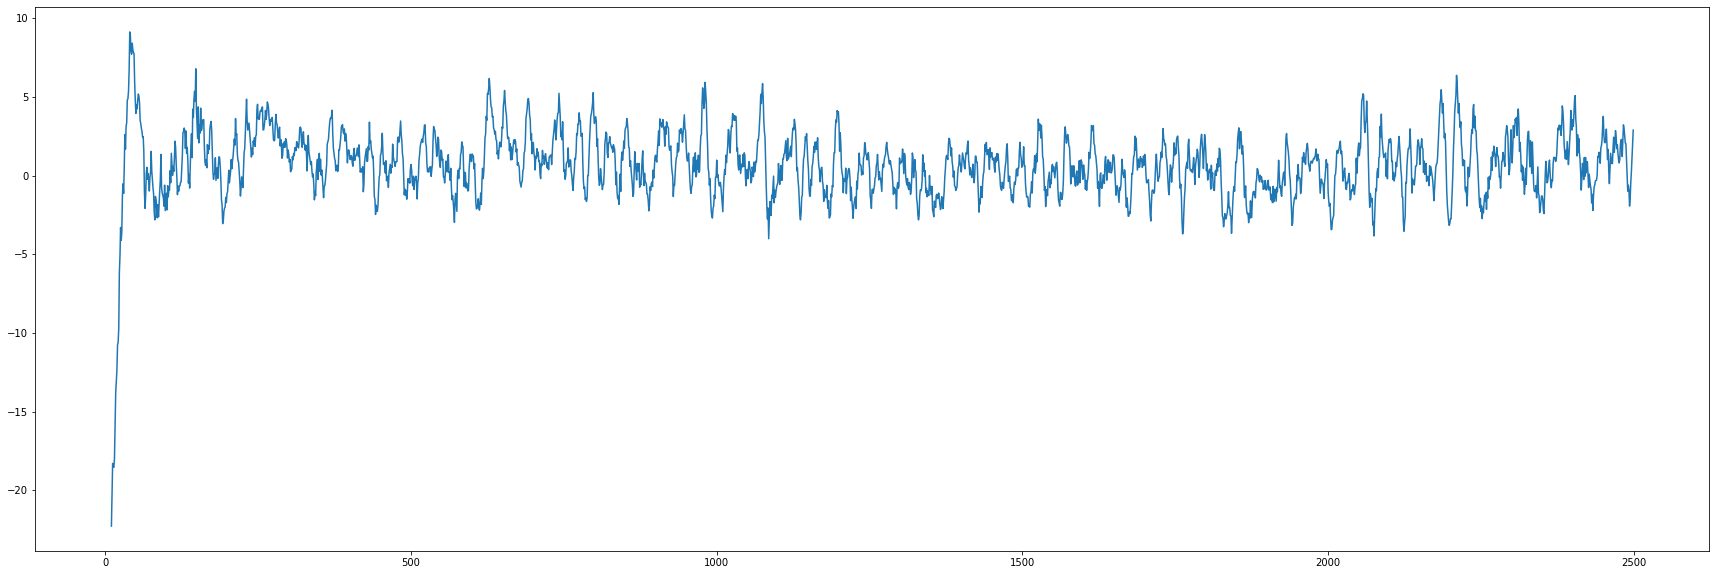

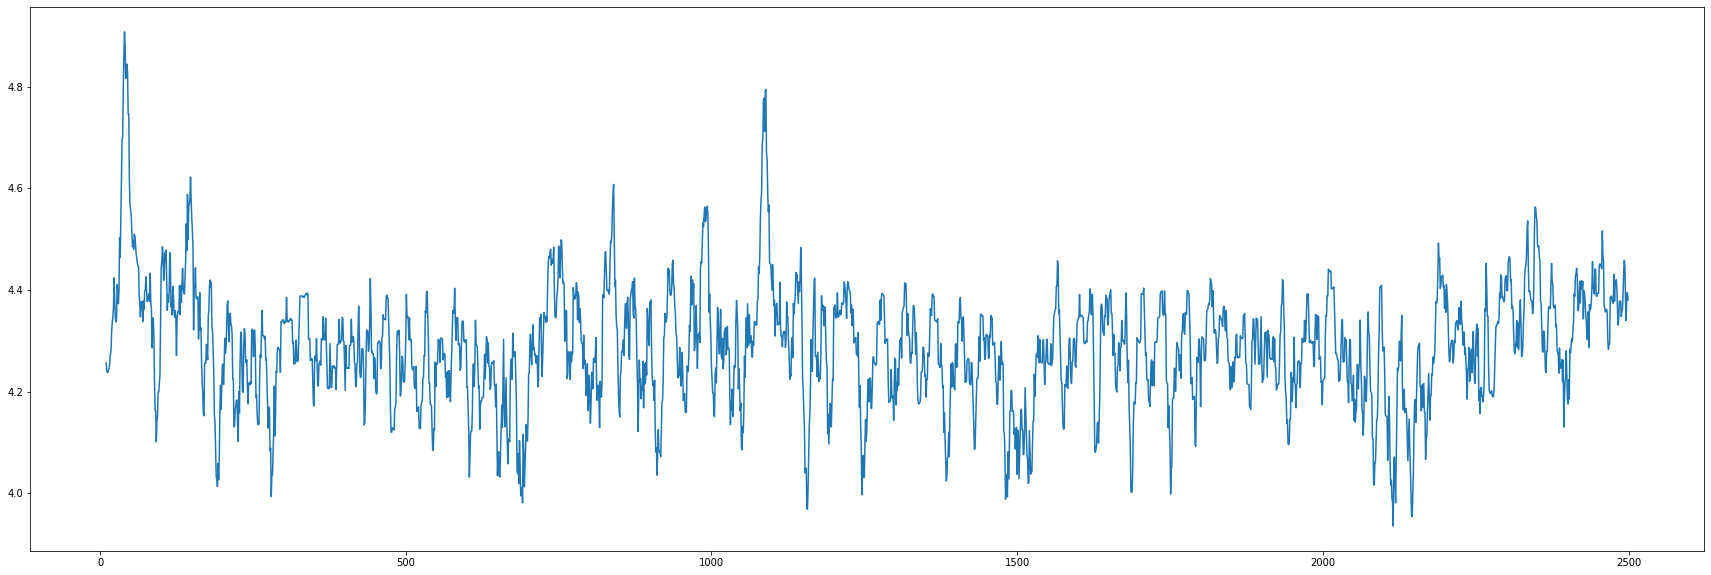

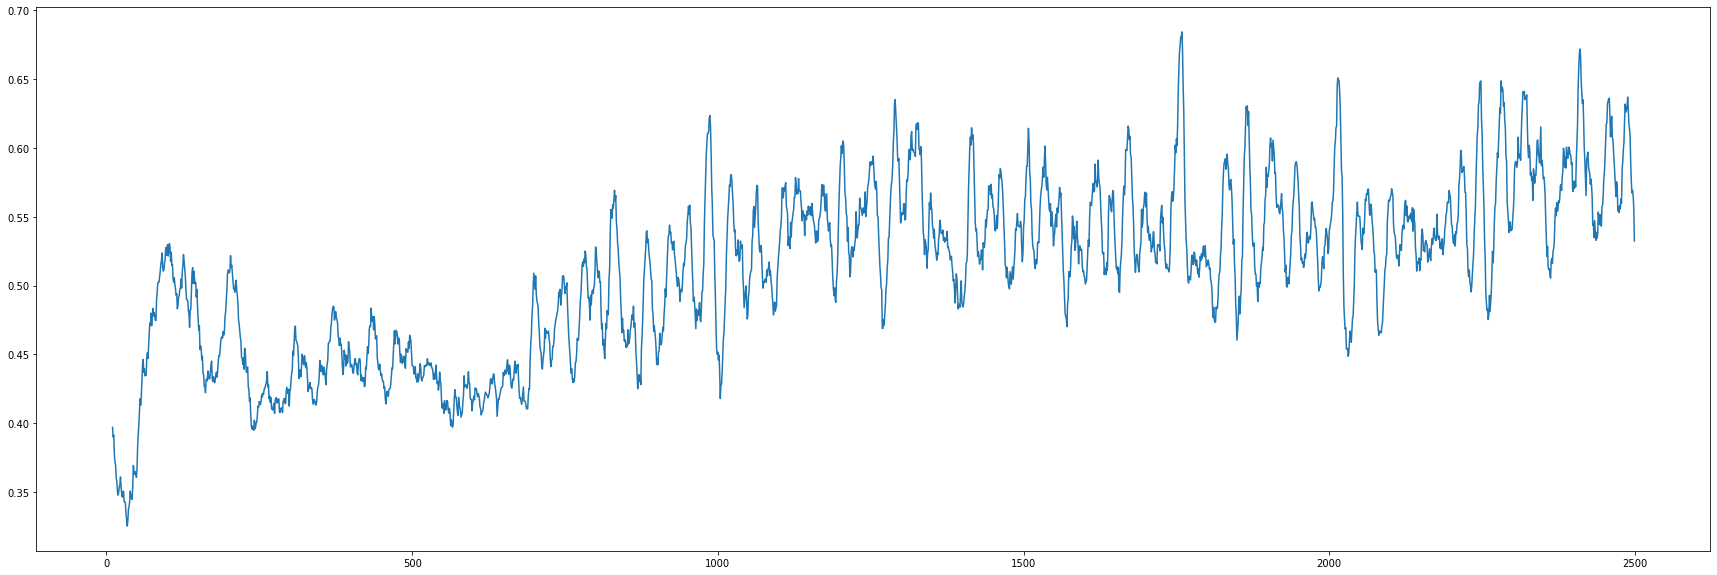

In [31]:
for i in range(3):
    plt.figure(figsize=(30,10))
    plt.plot(loss_1_df[f'loss_{i+1}'][10:])
    plt.show()
    
for i in range(3):
    plt.figure(figsize=(30,10))
    plt.plot(loss_2_df[f'loss_{i+1}'][10:])
    plt.show()

In [32]:
eval_df = trainer.evaluate()

In [33]:
eval_df

,agent_1,agent_2,random_agent,greedy_agent
agent_1,0,800,678,700
agent_2,0,0,677,607
random_agent,101,97,0,0
greedy_agent,89,163,0,0


In [35]:
torch.save( trainer.agent_1.model.state_dict(), "a2c_1_param1")
torch.save( trainer.agent_2.model.state_dict(), "a2c_2_param1")